# Métricas en clasificación

Este notebook, by [Felipe Alonso Atienza](www.linkedin.com/in/felipe-alonso-atienza)

En este Notebook vamos analizar distintas métricas y algoritmos sobre un problema de clasificación desbalanceado. 

## Contenidos

1. Análisis exploratorio
2. Métricas clasificación
3. Comparación clasificadores

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

# 1. Análisis exploratorio

Vamos a trabajar con datos de fuga de una compañía telefónica. El objetivo es predecir cuándo los clientes van a abandonar la compañía.

<div class = "alert alert-success">
**EJERCICIO**: Cargue los datos *churn.csv* y realice un primer análisis de los datos cargados
</div>

<div class = "alert alert-success">
**EJERCICIO**: Este problema está desbalanceado, calcule el ratio de desbalanceo
</div>

In [3]:
data = pd.read_csv('./data/churn.csv',sep=",", decimal='.')
print('filas, columnas: ', data.shape)
data.head()

filas, columnas:  (3333, 21)


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
data['churn'].value_counts() / data.shape[0]

False    0.855086
True     0.144914
Name: churn, dtype: float64

In [5]:
data.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


##  1.1 preprocesamiento de variables

Si escribimos *data.dtypes* nos indica el tipo de las variables de nuestro dataframe. Vemos que tenemos variables categóricas que tenemos que codificar. 

<div class = "alert alert-success">
**EJERCICIO**: Elimine la variable *phone number* y codifique las variables categóricas.
</div>

In [6]:
data = data.drop(['phone number'],axis=1)
print('filas, columnas: ', data.shape)

filas, columnas:  (3333, 20)


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['state']              = le.fit_transform(data['state'])
data['international plan'] = le.fit_transform(data['international plan'])
data['voice mail plan']    = le.fit_transform(data['voice mail plan'])

data['churn']  = le.fit_transform(data['churn'])

data.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


<div class = "alert alert-success">
**EJERCICIO**: Represente el histograma de las variable con distintos colores para cada clase.
</div>

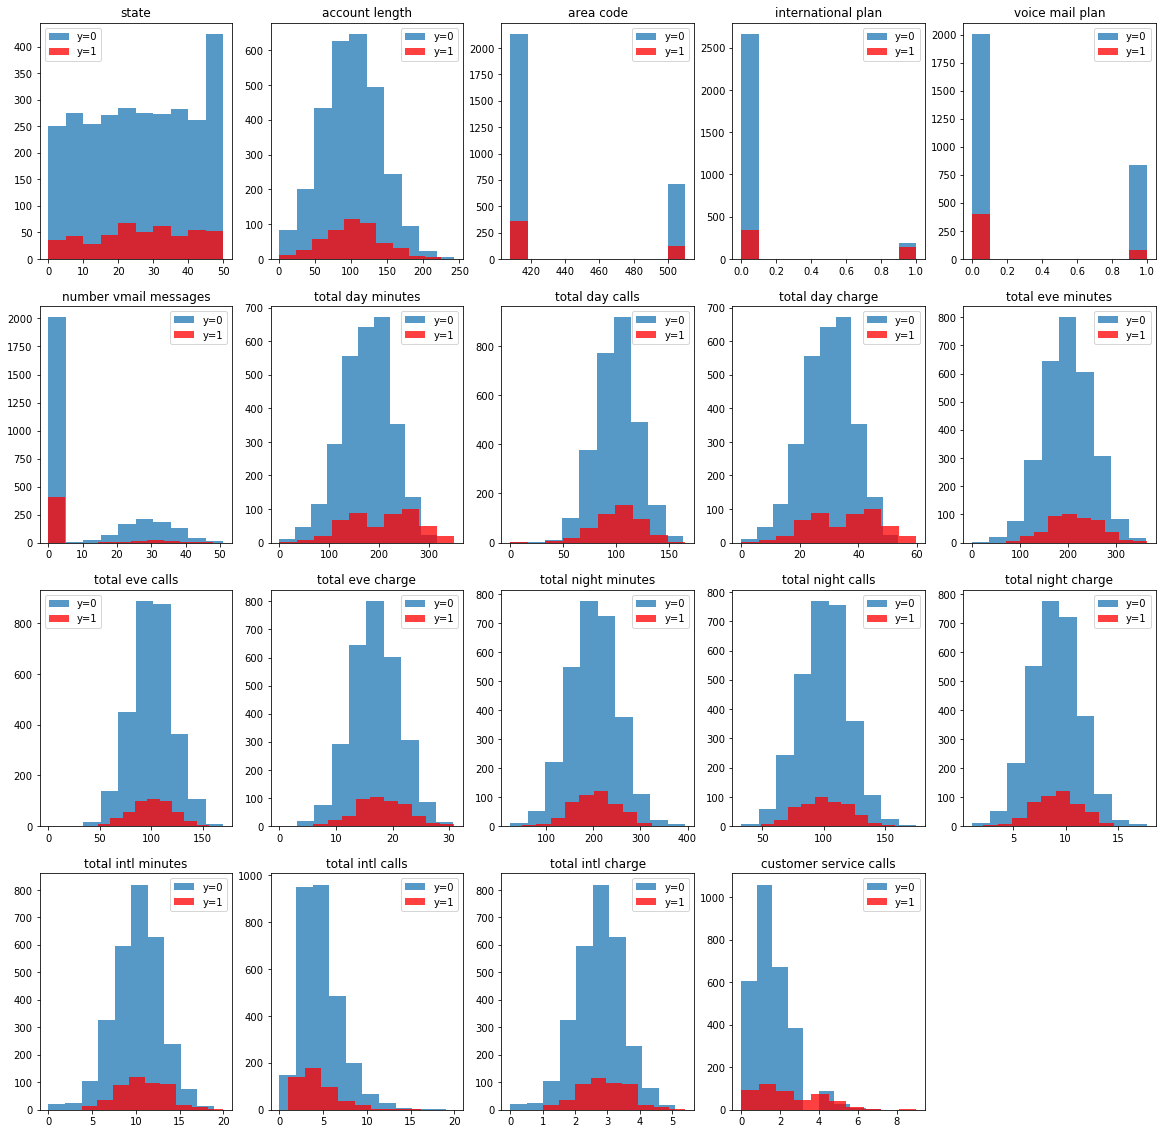

In [8]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['churn'] == 0
idx_1 =  data['churn'] == 1

for i,feature in enumerate(data.columns.drop(['churn'])):
    plt.subplot(4,5,i+1)   
    plt.hist(data.ix[idx_0,feature],normed=0, alpha=0.75,label='y=0')
    plt.hist(data.ix[idx_1,feature],normed=0, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

## 1.2 Correlación entre variables

<div class = "alert alert-success">
**EJERCICIO**: Represente el mapa de correlación entre variables
</div>

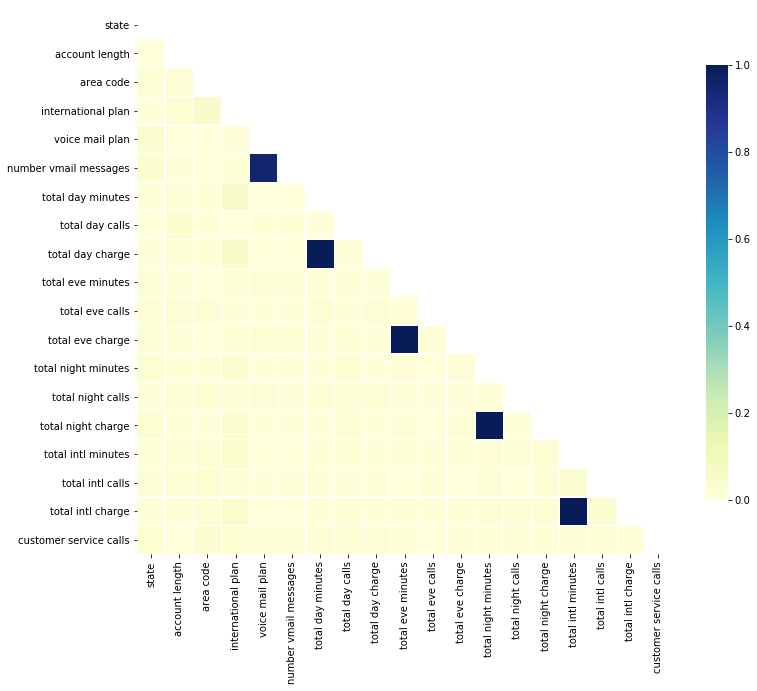

In [9]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(data.drop(['churn'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

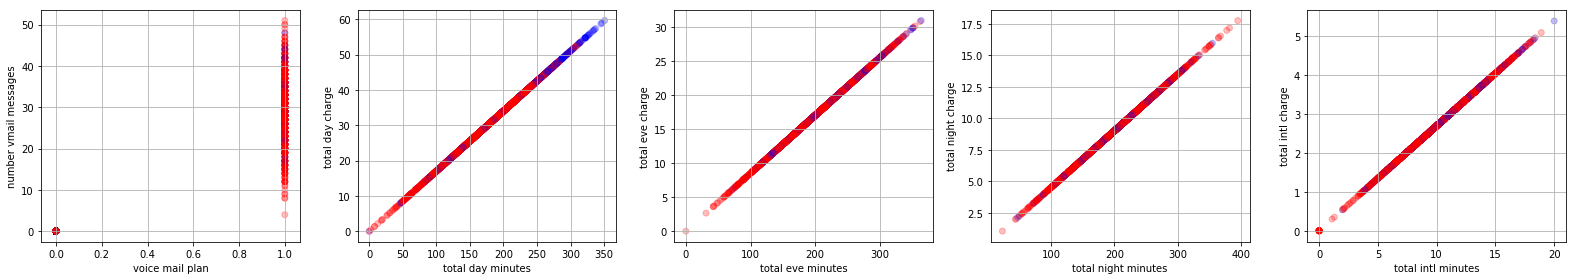

In [10]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
pairs = np.where(upper>0.95)
fx = data.columns[pairs[0]]
fy =  data.columns[pairs[1]]

i=1
plt.figure(figsize=(22,4))
for f1,f2 in zip(fx,fy):
    
    plt.subplot(1,5,i)
    
    plt.scatter(data[f1],data[f2], c=data['churn'],cmap=cm_bright, alpha=0.25)
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.grid()
    plt.tight_layout()
    
    i+=1
    
plt.show()

En clasificación, variables correlacionadas no afectan al proceso de clasificación. Sin embargo, dada la correlación extrema y con el objetivo de eliminar variables poco informativas, podemos eliminar algunas columnas.

In [11]:
columns_to_drop = ['total day minutes','total eve minutes','total night minutes','total intl minutes']

# 2. Métricas en clasificación

Vamos a representar la matriz de confusión, y a partir de ella calcular distintas métricas. Para ello, comencemos un clasificador sencillo: regresión logística.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# preparamos los datos

columns_to_drop.append('churn')
features = data.columns.drop(columns_to_drop)

X = data[features].as_matrix()
y = data['churn'].as_matrix()


# PASO 1:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=0)

scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test  = scaler.transform(X_test)

print('Datos train: ', Xs_train.shape)
print('Datos test:  ', Xs_test.shape)

print('Propocion train:%0.3f'%np.mean(y_train))
print('Propocion test: %0.3f'%np.mean(y_test))


Datos train:  (2499, 15)
Datos test:   (834, 15)
Propocion train:0.145
Propocion test: 0.145


## 2.1 Matriz de confusión y métricas

<div class = "alert alert-success">
**EJERCICIO**: Ajuste un algoritmo de regresión logística sobre el conjunto de entrenamiento con $C = 1$. Calcule la predicción para el conjunto de entrenamiento (*y_pred*).
</div>

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1).fit(Xs_train,y_train)
y_pred = lr.predict(Xs_train)

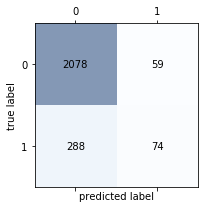

In [14]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_train,y_pred)
plot_confusion_matrix(confmat)

# Podemos acceder a los valores de la matriz
tn, fp, fn, tp = confusion_matrix(y_train,y_pred).ravel()

<div class = "alert alert-success">
**EJERCICIO**: A partir de las TP, TN, FP, FN, calcula las siguiente métricas: SEN, ESP, PPV, FSC, ACC.
</div>

In [15]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

ACC:  0.861144457783
SEN:  0.204419889503
ESP:  0.97239120262
PPV:  0.556390977444
FSC:  0.29898989899


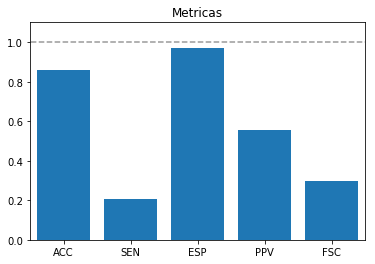

In [16]:
calcula_metricas(confmat)

<div class = "alert alert-success">
**EJERCICIO**: Calcula las métricas de performance en el conjunto de test.
</div>

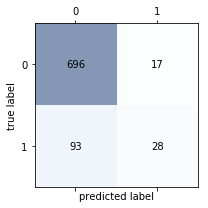

ACC:  0.868105515588
SEN:  0.231404958678
ESP:  0.976157082749
PPV:  0.622222222222
FSC:  0.33734939759


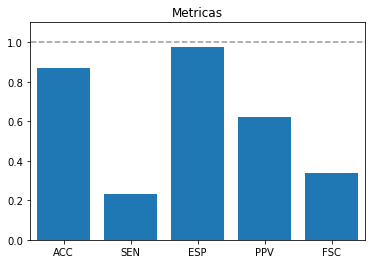

In [17]:
y_pred_test = lr.predict(Xs_test)

# your code here
confmat_test = confusion_matrix(y_test,y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

<div class = "alert alert-success">
**EJERCICIO**: Representa el histograma de probabilidad estimada *y_prob* para el conjunto de test. Representa de distinto color cada una de las clases. 
</div>

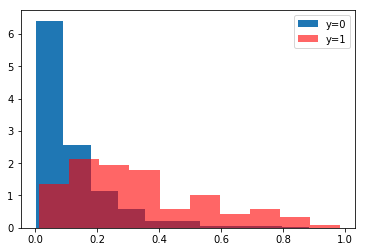

In [18]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

Por último, vamos a representar la curva ROC.

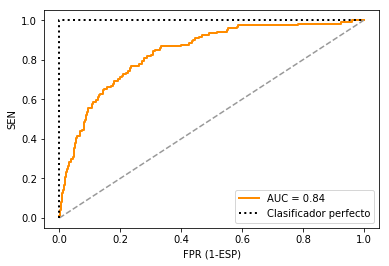

In [19]:
from sklearn.metrics import roc_curve, auc

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.legend(loc="lower right")
plt.show()

# 3. Comparación clasificadores

Vamos a comparar los siguientes clasificadores: 

* Regresión logística
* Árboles de decisión
* Máquinas de vectores soporte en clasificación: SVC
* Random Forest

<div class = "alert alert-success">
**EJERCICIO**: Calcule los parámetros libres óptimos para cada clasificador. Ajuste un modelo con dichos parámetros y compare las métricas obtenidas con cada uno de ellos
</div>

## 3.1 Regresión logística

Hemos visto que este algoritmo está sesgado hacia la clase mayoritoria. Para compensar esta situación, podemos asignar pesos distintos a los errores cometidos en cada una de las clases, a través del parámetro [*class_weight*](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Además, podemos trabajar con distintas [métricas](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) a la hora de optimizar los parámetros libres. Para conjuntos desbalancedados es adecuada:

* 'f1': F1-score, compromiso entre SEN, y PPV.


best mean cross-validation score: 0.484
best parameters: {'C': 1.9952623149688788}


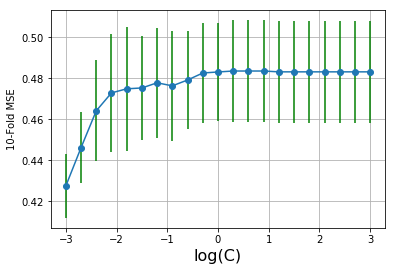

In [20]:
from sklearn.model_selection import GridSearchCV

vectorC = np.logspace(-3,3,21)
param_grid = {'C': vectorC }

grid = GridSearchCV(LogisticRegression(random_state=0, class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.errorbar(np.log10(vectorC),scores,yerr=std_scores, fmt='o-',ecolor='g')
plt.xlabel('log(C)',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.grid()
plt.show()

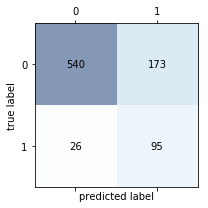

ACC:  0.76139088729
SEN:  0.785123966942
ESP:  0.757363253857
PPV:  0.35447761194
FSC:  0.488431876607


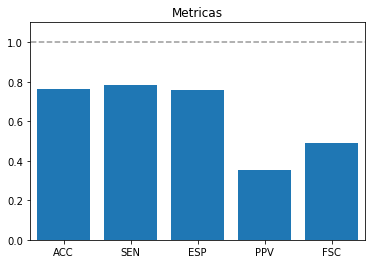

In [21]:
Copt = grid.best_params_['C']

lr = LogisticRegression(random_state=0, C = Copt, class_weight='balanced').fit(Xs_train,y_train)
y_pred = lr.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

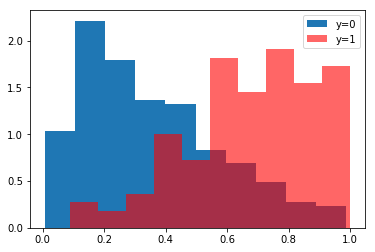

In [22]:
y_prob = lr.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Compare el resultado con respecto a entrenar maximizando *accuracy* y sin balancear las clases.
</div>

<div class = "alert alert-success">
**EJERCICIO**: Una vez fijados los parámetros libres, represente la curva ROC. 
</div>

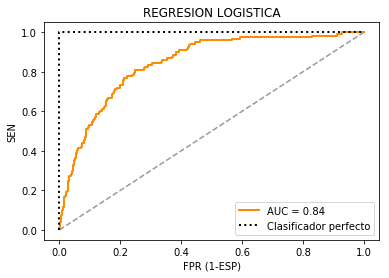

In [23]:
from sklearn.metrics import roc_curve, auc

y_prob = lr.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('REGRESION LOGISTICA')
plt.legend(loc="lower right")
plt.show()

## 3.2 Árboles de decisión

Entrenamos ahora un árbol de decisión. Otra ventaja adicional de los árboles es que por su construcción hace frente al desbalanceo de las clases.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un árbol de decisión y calcula las métricas obtenidas en el conjunto de test.
</div>

best mean cross-validation score: 0.748
best parameters: {'max_depth': 5}


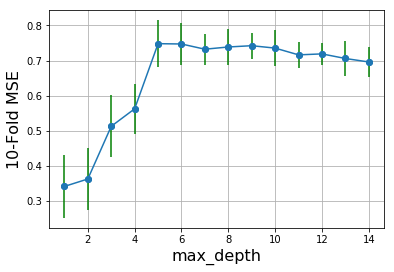

In [30]:
from sklearn.tree import DecisionTreeClassifier

maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }

grid = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.plot(maxDepth,scores,'-o')
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o',ecolor='g')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE',fontsize=16)
plt.grid()
plt.show()

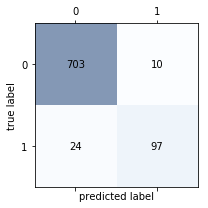

ACC:  0.959232613909
SEN:  0.801652892562
ESP:  0.985974754558
PPV:  0.906542056075
FSC:  0.850877192982


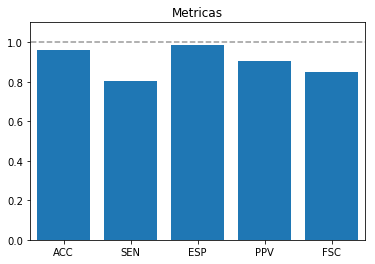

In [31]:
depthOpt = grid.best_params_['max_depth']

tree = DecisionTreeClassifier(random_state=0, max_depth= depthOpt).fit(Xs_train,y_train)
y_pred = tree.predict(Xs_test)

confmat_test  = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

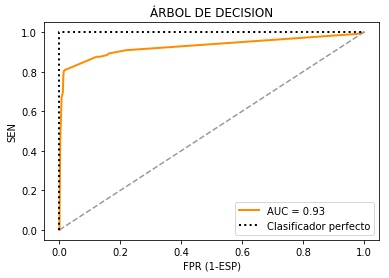

In [32]:
y_prob = tree.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('ÁRBOL DE DECISION')
plt.legend(loc="lower right")
plt.show()

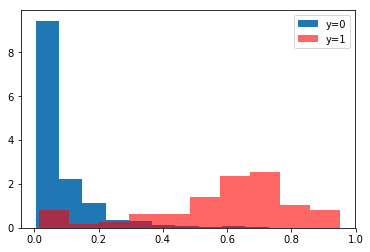

In [52]:
y_prob = tree.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**: Visualiza el árbol de decisión entrenado para comprender las predicciones realizadas.
</div>

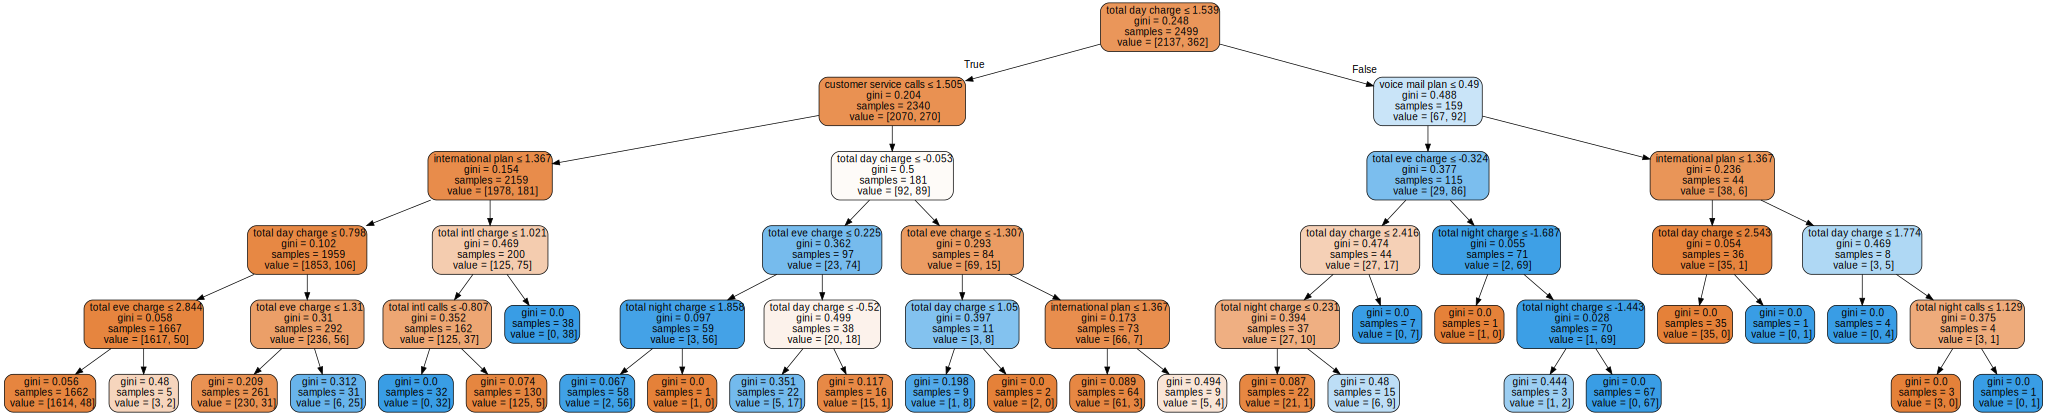

In [29]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=features,  
                         #class_names=['apple','mandarin','orange','lemon'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

## 3.3 Random Forest

Comprobemos prestaciones para un algoritmo de Random Forest.

<div class = "alert alert-success">
**EJERCICIO**: Entrena un algoritmo de Random Forest y calcula las métricas obtenidas en el conjunto de test.
</div>

best mean cross-validation score: 0.740
best parameters: {'max_depth': 9}


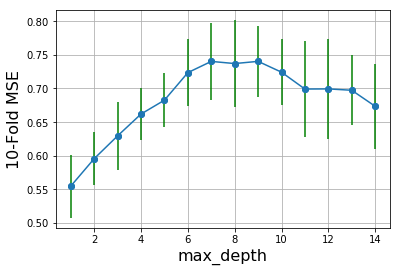

In [57]:
from sklearn.ensemble import RandomForestClassifier

# grid search
maxDepth   = range(1,15)
param_grid = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0,n_estimators = 200, max_features='sqrt', class_weight='balanced'),
                    scoring='f1', 
                    param_grid=param_grid, 
                    cv = 10)

grid.fit(Xs_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score']
std_scores = grid.cv_results_['std_test_score']
plt.plot(maxDepth,scores,'-o')
plt.errorbar(maxDepth,scores,yerr=std_scores, fmt='o',ecolor='g')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE',fontsize=16)
plt.grid()
plt.show()

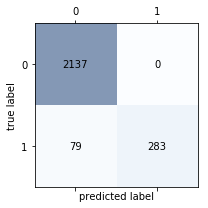

ACC:  0.968387354942
SEN:  0.781767955801
ESP:  1.0
PPV:  1.0
FSC:  0.877519379845


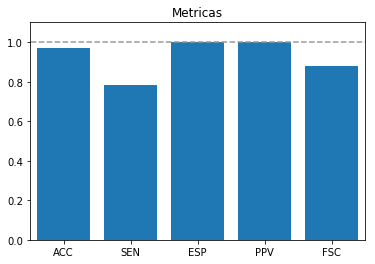

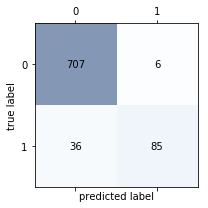

ACC:  0.94964028777
SEN:  0.702479338843
ESP:  0.991584852735
PPV:  0.934065934066
FSC:  0.801886792453


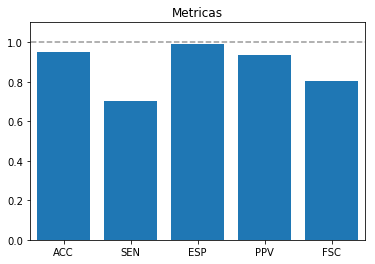

In [62]:
depthOpt = grid.best_params_['max_depth']

rf = RandomForestClassifier(random_state=0,
                            max_depth=depthOpt,
                            n_estimators = 200,
                            #class_weight='balanced',
                            max_features='sqrt').fit(Xs_train,y_train)

y_pred_train = rf.predict(Xs_train)
y_pred_test  = rf.predict(Xs_test)

confmat_train  = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(confmat_train)
calcula_metricas(confmat_train)

confmat_test  = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(confmat_test)
calcula_metricas(confmat_test)

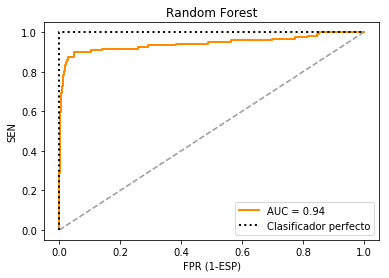

In [63]:
y_prob = rf.predict_proba(Xs_test)[:,1]

ejex, ejey, _ = roc_curve(y_test, y_prob)
roc_auc = auc(ejex, ejey)

plt.figure()
plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Clasificador perfecto')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('FPR (1-ESP)')
plt.ylabel('SEN')
plt.title('Random Forest')
plt.legend(loc="lower right")
plt.show()

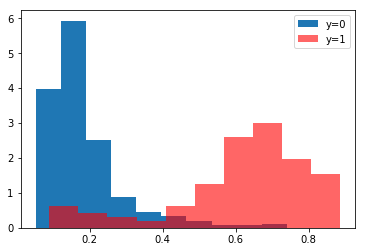

In [60]:
y_prob = rf.predict_proba(Xs_test)[:,1]

idx_0 = (y_test==0)
idx_1 = (y_test==1)

# your code here
plt.hist(y_prob[idx_0], normed = 1, label = 'y=0')
plt.hist(y_prob[idx_1], normed = 1, facecolor = 'r',alpha=0.6, label = 'y=1')
plt.legend(loc=1)
plt.show()

<div class = "alert alert-success">
**EJERCICIO**@home: Entrena una SVM y Boosted Trees
</div>